In [1]:
import numpy as np
import librosa
from joblib import Parallel, delayed
import pandas as pd
import jams
import os

In [2]:
def analyze(audio_file, sr=44100., hop_length=1024, duration=4.0, os=3, n_octaves=7, fmin=librosa.note_to_hz('C1'), harmonics=(1,2,3,5)):
    
    y, sr = librosa.load(audio_file, sr=sr)
    
    if duration is not None:
        y = librosa.util.fix_length(y, int(duration * sr))
        
    cqt_f = librosa.cqt_frequencies(n_octaves * os * 12, fmin, bins_per_octave=os * 12)
    
    C = np.abs(librosa.cqt(y=y, sr=sr, hop_length=hop_length, n_bins=n_octaves * os * 12, bins_per_octave=os * 12, tuning=0.0))
    
    return librosa.harmonics(C, cqt_f, harmonics)

In [9]:
def ofilename(audio_file, destdir):
    
    return os.path.join(destdir, 'features', os.path.extsep.join([os.path.basename(audio_file), 'npz']))

In [4]:
def process(audio_file, destdir, **kwargs):
    
    Ch = analyze(audio_file, **kwargs)
    
    of = ofilename(audio_file, destdir)
    
    np.savez(of, C=Ch)

In [12]:
SRCDIR = '/home/bmcfee/data/minst/'
DESTDIR = '/home/bmcfee/working/minst/'

In [13]:
audio_files = jams.util.find_with_extension(os.path.join(SRCDIR, 'note_files'), ext='flac')

In [14]:
Parallel(n_jobs=24, verbose=1)(delayed(process)(af, DESTDIR, duration=1.0) for af in audio_files);

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:   15.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:   20.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:   25.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:   31.3s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   37.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   45.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   53.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 11202 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 12752 tasks      | elapsed:  1

---
# Experiment control files

In [15]:
import json

In [62]:
meta = pd.read_csv(os.path.join(SRCDIR, 'master_index.csv'))

In [63]:
meta.columns

Index(['Unnamed: 0', 'audio_file', 'dataset', 'duration', 'dynamic',
       'instrument', 'note_number', 'partition', 'source_index', 'start_time'],
      dtype='object')

In [64]:
meta = meta.rename(columns={meta.columns[0]: 'source_id', 'audio_file': 'filename'})

In [65]:
meta.instrument.unique()

array(['Trumpet', 'Horn', 'TenorTrombone', 'Tuba', 'Guitar', 'Cello',
       'Bass', 'Violin', 'Bassoon', 'BbClar', 'EbClar', 'Flute', 'Oboe',
       'guitar-acoustic-nylon', 'guitar-acoustic-steel', 'violin', 'cello',
       'bass-double', 'trumpet', 'trombone', 'tuba', 'horn-french', 'oboe',
       'bassoon', 'clarinet', 'flute', 'double-bass', 'french-horn',
       'guitar'], dtype=object)

In [66]:
instmap = {'Trumpet': 'trumpet',
           'trumpet': 'trumpet',
           'acoustic-guitar': 'guitar',
           'guitar-acoustic-steel': 'guitar',
           'guitar-acoustic-nylon': 'guitar',
           'Guitar': 'guitar',
           'guitar': 'guitar',
           'bassoon': 'bassoon',
           'Bassoon': 'bassoon',
           'Cello': 'cello',
           'cello': 'cello',
           'clarinet': 'clarinet',
           'Clarinet': 'clarinet',
           'BbClar': 'clarinet',
           'EbClar': 'clarinet',
           'bass-double': 'double-bass',
           'Bass': 'double-bass',
           'double-bass': 'double-bass',
           'Flute': 'flute',
           'flute': 'flute',
           'horn-french': 'horn-french',
           'french-horn': 'horn-french',
           'Horn': 'horn-french',
           'Oboe': 'oboe',
           'oboe': 'oboe',
           'trombone': 'trombone',
           'TenorTrombone': 'trombone',
           'Tuba': 'tuba',
           'tuba': 'tuba',
           'Violin': 'violin',
           'violin': 'violin'
          }

In [75]:
classids = {x: i for i, x in enumerate(sorted(set(instmap.values())))}

In [76]:
folds = {'uiowa': 1, 'philharmonia': 2, 'rwc': 3}

In [77]:
meta['class'] = [instmap[x] for x in meta['instrument']]
meta['classID'] = [classids[x] for x in meta['class']]
meta['fold'] = [folds[x] for x in meta['dataset']]

In [78]:
for fold in range(1, 3):
    train_split = meta[meta['fold'] != fold]
    test_split = meta[meta['fold'] == fold]
    
    train_split = train_split[['filename', 'classID']]
    test_split = test_split[['filename', 'classID']]
    
    with open(os.path.join(DESTDIR, 'experiment_{:02d}.json'.format(fold)), 'w') as fdesc:
        json.dump({'train': train_split.to_dict('records'),
                   'test': test_split.to_dict('records')},
                  fdesc, indent=2)

In [79]:
meta.head(5)

,source_id,filename,dataset,duration,dynamic,instrument,note_number,partition,source_index,start_time,class,classID,fold
0,uiowaa882898d02a286,uiowaa882898d02a286.flac,uiowa,9.073197,ff,Trumpet,NaN,NaN,uiowaa882898d,3.047619,trumpet,9,1
1,uiowaa882898d1eb7d2,uiowaa882898d1eb7d2.flac,uiowa,8.980317,ff,Trumpet,NaN,NaN,uiowaa882898d,12.120816,trumpet,9,1
2,uiowaa882898de58d9e,uiowaa882898de58d9e.flac,uiowa,8.632018,ff,Trumpet,NaN,NaN,uiowaa882898d,21.101134,trumpet,9,1
3,uiowaa882898d2659f4,uiowaa882898d2659f4.flac,uiowa,8.870023,ff,Trumpet,NaN,NaN,uiowaa882898d,29.733152,trumpet,9,1
4,uiowaa882898dbd12c0,uiowaa882898dbd12c0.flac,uiowa,9.131247,ff,Trumpet,NaN,NaN,uiowaa882898d,38.603175,trumpet,9,1


---
# Debugging

In [17]:
audio_files[-119]

'/home/bmcfee/data/UrbanSound8K/audio/fold9/66601-8-0-4.wav'

In [18]:
Ch = analyze(audio_files[-119])

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import librosa.display

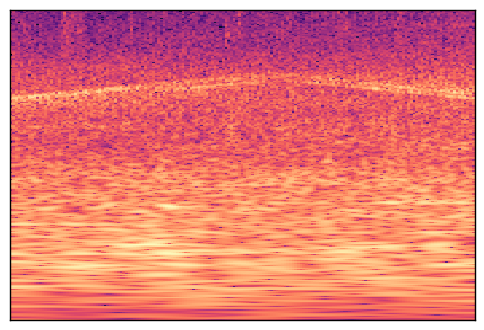

In [19]:
librosa.display.specshow(librosa.logamplitude(Ch[0]**2, ref_power=np.max))